# TO DO

- To Do:
  - "ROC AUC and Precision-Recall AUC provide scores that summarize the curves and can be used to compare classifiers." https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
  - "We've established that our "accuracy" score is now a more meaningful score used for validation of a given model, but "recall, precision, and F-statistic" may be better indicators of whether the model is doing a "good job"
  - Make sure you have everything in checklist
    - README uses notebook, slideshow uses README
  - Justify gridsearch parameters!!!!!!!!!! 
    - https://saturncloud.io/blog/how-to-optimize-logistic-regression-with-gridsearchcv-in-pythons-scikitlearn/
    - What do we start with in terms of a list of parameters to search?
  - Goodness of fit:
    - Something like this:
    - Split Number  1
      Accuracy= 0.9454545454545454
      Precision= 0.94375
      Recall= 1.0

      Split Number  2
      Accuracy= 0.9757575757575757
      Precision= 0.9753086419753086
      Recall= 1.0

      Split Number  3
      Accuracy= 0.9695121951219512
      Precision= 0.9691358024691358
      Recall= 1.0  

- Although overfitting is a useful tool for analysis, it must not be confused with model selection.
  - https://machinelearningmastery.com/overfitting-machine-learning-models/
- To determine overfitting/underfitting, could use learning curves: 
  - https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5
  - https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

Hyperparameters:
  - AUC/ROC: Adjusting this threshold will help reduce false negatives (lecture #40)
  - The true- and false-positive rates will change if we make adjustments to the threshold. In fact, in the present case that was the whole point of making the adjustment: We want to minimize our false negatives.

- Log-Loss:
  - Add one more model to improve upon log-loss?
  - Yes, log loss can be used to compare models! https://hyperskill.org/learn/step/15760

- Why SMOTE:
  - We use SMOTE because we are very concerned with mislabeling the minority class (churned) as the majority class (has not churned)
  - If we accidently commit a false negative , then we lose out on business and we lose out on a chance to see WHY that customer churned. It matters less if we mislabel those who have not churned(0) as those who will churn (1), because we'd like to be on the safe side to incentivize a customer to stay even if they're already happy.
  - Why use log loss? Models with lower loss values generate probability estimates that are closer to the true values, and thus are likely to perform better on many metrics.

# Business Understanding
My stakeholders are the customer retention analytics (CRA) team at a telecoms company "SyriaTel." The CRA team uses data we provide them to create dashboards and slide decks to justify changes in the customer experience with the goal of reducing customer churn. The objective of this project is to predict which customers who will "churn" (leave our phone plan), given the data in our training set associated with each plan subscriber. This way we can identify the customers before they churn, and identify ways to incentivize them to stay. The problem of predicting which customers who will churn is suitable for logistic regression because the outcome we want to predict is categorical rather than a continuous numerical variable. While using a machine learning model rather than inferential statistics isn't "better" - it's a useful place to start. It allows us to predict the customers who have not churned yet but are likely to. The logistic regression model produced by this project examines parameters that validate how accurately the model can predict customer churn. Further down the road, we can use other types of model coefficients, inferential methods and statistical tests to determine which variables are most likely to be causing churn - and that allows us to strategize how to prevent customers from leaving if we know the reasons why. However, having the predictive model is invaluable to continually update the CRA team about which customers are likely to churn soon, so that they can take steps to prevent it.

# Data Understanding


| Variable | Definition | Key/Notes |
| -------- | -------- | -------- |  
| churn | Has customer ceased doing business with SyriaTel | False = has not churned, True = has churned 
| state | US State | Categorical number that must be one-hot-encoded. NOT ordinal.|
| account length | Smaller number (length) indicates older account | |
| area code | Phone number area code | |
| phone number | Phone number | |
| international plan | Customer has intl. plan | 'yes', 'no'(note: although categorical, this is already "one hot encoded" because it is binary) |
| voice mail plan | Customer has voice mail plan | 'yes', 'no'(see above)|
| number vmail messages | | | |
| total day minutes
| total day calls
| total day charge
| total eve minutes
| total eve calls
| total eve charge
| total night minutes
| total night calls
| total night charge
| total intl minutes
| total intl calls
| total intl charge
| customer service calls

# Get Data and Import Libraries:

In [1508]:
# Import Required Python Libraries:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import stripplot
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

# Define Modeling Class ModelWithCV()
- Adapted from Flatiron School's Phase03, Lecture #42, "Workflow with Pipelines"
- This class inputs a model and outputs a crossvalidation score based on training data + visualizations
- I'm going to add `log_loss` to the cross validation results because it's analogous to Root-mean squared error, which looks at average of difference between the predicted probabilities (from logistic regression) of how far off our predicted class is from an individual's actual class is.
- It's basically a overall measure of how well the model is doing.
- For interpreting `log_loss`, the smaller the value, the better.

In [1509]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        # Claire Sarraille: Added log_loss for list of results:
        self.cv_neg_log_loss = cross_val_score(self.model, cv_X, cv_y, scoring ="neg_log_loss")
        self.cv_log_loss = -(self.cv_neg_log_loss.mean())

        # To-Do: Claire Sarraille: Added precision, recall, and F-Measure:
   
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            Accuracy: {self.cv_mean:.5f} ± {self.cv_std:.5f}
            Log Loss: {self.cv_log_loss:.5f}
            10-fold Cross Validation Scores: {self.cv_results}
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Claire Sarraille: Customized plot for cv results
        sns.boxplot(self.cv_results, ax=ax)

        return ax

In [1510]:
# Import Data:
df = pd.read_csv('./data.csv')

# Initial EDA
- Explore variables
- Nulls? 
- Categorical, binary, or numerical?

In [1511]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [1512]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


## To do: What we getting out of this

In [1513]:
df.value_counts('international plan')

international plan
no     3010
yes     323
dtype: int64

In [1514]:
df.value_counts('voice mail plan')

voice mail plan
no     2411
yes     922
dtype: int64

In [1515]:
df.value_counts('account length')

account length
105    43
87     42
101    40
93     40
90     39
       ..
199     1
191     1
188     1
175     1
243     1
Length: 212, dtype: int64

In [1516]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

## Thoughts on Data (Consider the business problem when choosing features)
- Area codes (and by associate phone numbers) and State do not match (415 is not an area code in Kansas)
- "State" may be a useful geographical feature to consider, but lots of people live in states that don't match their phone #'s area code, so area code isn't a reliable indicator of location.
- There are no nulls
- Categorical Variables (besides target which is Churn)
- ## Numeric vs. Categorical:
  - Is it numeric or categorical?
    - As "Is an increase of 2 in this variable twice as much as an increase of 1?"
  - State
- These are boolean value columns - so they don't need to be one-hot-encoded, just converted from yes/no to 1/0
  - international plan
  - voice mail plan
- Ordinal values -- there are none
- To Drop:
  -   Area Code (because an increase of 1 does'nt mean twice as many)
  -   Phone number (because an increase of 1 does'nt mean twice as many)
- Calls vs. Minutes
  - The more calls doesn't necessarily mean more minutes, so we will keep calls and minutes (they are not redundant)

# Data Cleaning

In [1517]:
# Convert yes/no values to 0/1:
df['international plan'] = df['international plan'].replace(to_replace=['no', 'yes'], value=[0, 1])
df['voice mail plan'] = df['voice mail plan'].replace(to_replace=['no', 'yes'], value=[0, 1])

In [1518]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [1519]:
# Convert target variable from True/False to 1/0
# Prior convention: False = has not churned, True = has churned 
# We will convert to this convention: 0 = False, 1 = True
df['churn'] = df['churn'].replace(to_replace=[False, True], value=[0, 1])

In [1520]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [1521]:
df.value_counts('state')

state
WV    106
MN     84
NY     83
AL     80
OH     78
WI     78
OR     78
WY     77
VA     77
CT     74
VT     73
MI     73
ID     73
UT     72
TX     72
IN     71
KS     70
MD     70
NJ     68
NC     68
MT     68
NV     66
CO     66
WA     66
MA     65
MS     65
RI     65
AZ     64
MO     63
FL     63
ME     62
NM     62
ND     62
NE     61
DE     61
OK     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
dtype: int64

In [1522]:
# We have an imbalanced dataset skewed towards False
df.value_counts('churn')

churn
0    2850
1     483
dtype: int64

# Train Test Split

In [1523]:
# Create X (predictors) and y (target) variables:
# Here we'll drop area code and phone number while we're at it:
X = df.drop(['area code', 'phone number','churn'], axis = 1).reset_index(drop=True)
y = df.churn.reset_index(drop=True)

# Split Data into train and test:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=666)

# Preview top 10:
X.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [1524]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 1777 to 2284
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2499 non-null   object 
 1   account length          2499 non-null   int64  
 2   international plan      2499 non-null   int64  
 3   voice mail plan         2499 non-null   int64  
 4   number vmail messages   2499 non-null   int64  
 5   total day minutes       2499 non-null   float64
 6   total day calls         2499 non-null   int64  
 7   total day charge        2499 non-null   float64
 8   total eve minutes       2499 non-null   float64
 9   total eve calls         2499 non-null   int64  
 10  total eve charge        2499 non-null   float64
 11  total night minutes     2499 non-null   float64
 12  total night calls       2499 non-null   int64  
 13  total night charge      2499 non-null   float64
 14  total intl minutes      2499 non-null

# Pipeline Set-Up

In [1525]:
# Define predictor features as list of numerical and list of categorical:

# List of numerical features:
numfeat = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']

# List of categorical features:
catfeat = ['state']

# Our boolean features are ['international plan', 'voice mail plan']
# Boolean features don't need to be scaled, so we will use "remainder='passthrough'"
# To indicate to compiler to let them through pipeline without transformations.

In [1526]:
# Pipeline for numerics:


# scale

numpipe = Pipeline([
    ('ss', StandardScaler())
])


In [1527]:
# Pipeline for categoricals:


# one-hot-encoder

catpipe = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')) # Using handle_unknown param en lieu of stratify during train-test-split
])

In [1528]:
# Pipeline for binaries:

# impute nulls

# binpipe = Pipeline([
#    ('binimp', SimpleImputer(strategy='most_frequent'))
#])

## We now have our numeric and categorical pipelines.
- Since we don't have any nulls, and binary features don't need to be transformed or one-hot-encoded,
- Our binary features don't have to be in a pipeline object
- Next step is to handle columns holistically with `ColumnTransformer`

In [1529]:
# We will use our pipeline objects as transformer argument for ColumnTransformer
# "Pipeline" has inherited a number of classes from our transforms (??)
# We don't need to do any transformations to the binary feature columns, so we use the 'passthrough'
# Argument to let them through without transformation.

# our transformer is a tuple and includes a columns argument

ColTrans = ColumnTransformer(transformers=[
    ('numerics', numpipe, numfeat),
    ('categoricals', catpipe, catfeat)
], remainder='passthrough')

# Dummy Model
- For our dummy model, the only variables we are excluding are "area code" and "phone number" because we've determined these columns don't contain information that signifies geographical location or any other information that would correlate to churn.

In [1530]:
# Create Dummy Model Pipeline

dumpipe = Pipeline([
    ('ct', ColTrans),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [1531]:
# Fit the dummy regressor to the training data:

dumpipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                 

## Output Mean Accuracy Score and Confusion Matrices for dummy model:

In [1532]:
# Get the score (predicts the likelihood of getting the majority class 
# by simply dividing majority/total positive class in training set: [2132/[2132 + 367]])
# Goal is for our next model to do better than this!


Dummy model TRAIN Mean Accuracy score: 0.85314

Target value counts
0    2132
1     367
Name: churn, dtype: int64


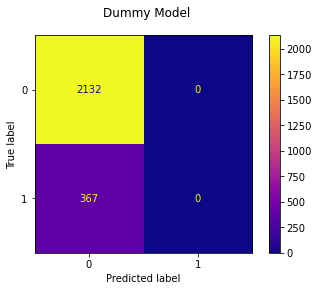

In [1533]:
# Training Data Confusion Matrix:

fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dumpipe, X_train, y_train, ax=ax, cmap="plasma");

print(f'Dummy model TRAIN Mean Accuracy score: {dumpipe.score(X_train, y_train):.5f}')
print(f'Dummy Model Log Loss: {dumpipe.score(X_train, y_train):.5f}')
print()
print('Target value counts')
print(y_train.value_counts())


        self.cv_neg_log_loss = cross_val_score(self.model, cv_X, cv_y, scoring ="neg_log_loss")
        self.cv_log_loss = -(self.cv_neg_log_loss.mean())

## Using Cross-Validation for model validation on "unseen" data rather than test dataset:

In [1534]:
# Now let's instantiate a dummy pipeline model and fit via inheritance from the ModelWithCV class:
dum_pipe_cv = ModelWithCV(
    dumpipe,
    model_name='dummy',
    X=X_train,
    y=y_train,
)

CV Results for `dummy` model:
            Accuracy: 0.85314 ± 0.00175
            Log Loss: 5.07231
            10-fold Cross Validation Scores: [0.852      0.852      0.852      0.852      0.852      0.852
 0.852      0.856      0.856      0.85542169]
        


/Users/claire/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

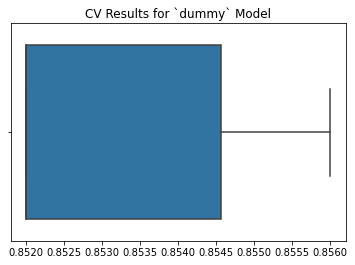

In [1535]:
fig, ax =plt.subplots()

dum_pipe_cv.print_cv_summary()

dum_pipe_cv.plot_cv(ax=ax)

## Interpreting Dummy Model Validation
- The accuracy score doesn't tell us much here - the dummy model simply predicts the majority class.
- Our log loss score is VERY high. We interpret it as the average difference between the predicted probabilities (from logistic regression) of how far off our predicted class is from an individual's actual class is.
- This is not a good model! But that is expected. It can only get better from here.
- Our Mean Accuracy score produced both via the confusion matrix AND cross-validation using our training data is the same (.85314).

# First Simple Model:

In [1536]:
# Create First Simple Model Pipeline

firstpipe = Pipeline([
    ('ct', ColTrans),
    ('fsm', LogisticRegression())
])

In [1537]:
# Fit the fsm regressor to the training data:

firstpipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                 

In [1538]:
firstpipe.preprocessed_train_scores

AttributeError: 'Pipeline' object has no attribute 'preprocessed_train_scores'

FSM model TRAIN Mean Accuracy score: 0.86995

Target value counts
0    2132
1     367
Name: churn, dtype: int64


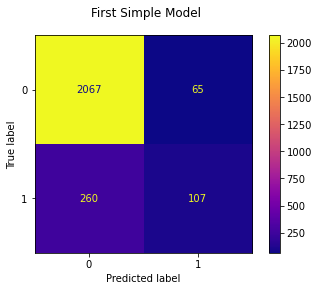

In [ ]:
# Training Data Confusion Matrix:

fig, ax = plt.subplots()

fig.suptitle("First Simple Model")

plot_confusion_matrix(firstpipe, X_train, y_train, ax=ax, cmap="plasma");

print(f'FSM model TRAIN Mean Accuracy score: {firstpipe.score(X_train, y_train):.5f}')
print()
print('Target value counts')
print(y_train.value_counts())

In [ ]:
first_pipe_cv = ModelWithCV(
    firstpipe,
    model_name='fsm',
    X=X_train,
    y=y_train
)


CV Results for `fsm` model:
            Accuracy: 0.85955 ± 0.02154
            Log Loss: 0.33334
            10-fold Cross Validation Scores: [0.868      0.86       0.892      0.872      0.848      0.868
 0.86       0.808      0.844      0.87550201]
        


/Users/claire/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

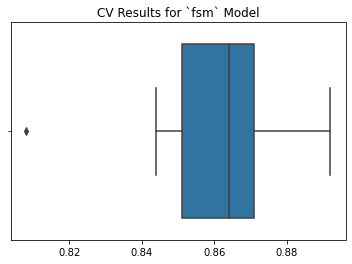

In [ ]:
fig, ax =plt.subplots()

first_pipe_cv.print_cv_summary()

first_pipe_cv.plot_cv(ax=ax)

## Interpreting First Simple Model Validation:
- Our log loss is much lower! That means we've decreased the average error between predicted and actual classes.
- Our mean accuracy is a bit higher than the dummy model, and because the mean accuracy is higher in cross-validation than training, it would apparently indicate overfitting.
- However, this information isn't super meaningful, because our class sizes are imbalanced, and accuracy is simply majority_class/sum of all classes (percentage of correctly predicted inputs). Accuracy is therefor quite "noisy."
- Log Less works better as a measure of performance, and is more easily interpreted both mathematically and intuitively.

## Add SMOTE to First Simple Model to address target class imbalance

- We're going to apply SMOTE to our first simple model right off the bat, because otherwise we won't be able to accurately estimate our model's accuracy.
- Note: SMOTE is generally better solution to class imbalance than under-sampling the majority class (using stratify parameter during train-test-split)
- I'm not sure that SMOTE is the best approach for this business problem, however. I need to look at the confusion matrix and determine whether predicting
- See: https://stats.stackexchange.com/questions/569935/smote-vs-stratified-sampling-in-highly-imbalanced-dataset-classification
  - The reason for balancing etc. is actually because the misclassification costs are not equal, but this has nothing to do with the imbalance per se, it is just that imbalanced learning problems tend to be ones with obviously unequal costs. For example, I suspect it is a far worse error to classify a patient as not being at risk of stroke when they are (they may go home untreated, have a stroke and die) than to classify them as at risk of stroke when they are not (they will just be subjected to unnecessary further testing). We should be considering misclassification costs anyway, regardless of imbalance.

In [ ]:
# We'll go ahead and just use Cross-validation for now to validate our first simple model
# But first, we need to address the class imbalance of our y_train
# If we don't address class imbalance now, our accuracy score won't be especially meaningful

# True = 1
# False = 0

# Is there a better way to address "misclassification costs" than using SMOTE?
# Here, if we don't address the imbalance, we'll have potentially more False negatives
# Which would mean we're missing people who are gonna churn.

print(y_train.value_counts())


0    2132
1     367
Name: churn, dtype: int64


In [ ]:
# Instantiate SMOTE object from class:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [ ]:

smotepipe = ImPipeline(steps=[
    ('ct', ColTrans),
    ('sm', SMOTE(random_state=42)),
    ('fsm', LogisticRegression(solver='saga'))
])

why saga

In [ ]:
smotepipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                 

SMOTE model TRAIN Mean Accuracy score: 0.79952

Target value counts
0    2132
1     367
Name: churn, dtype: int64


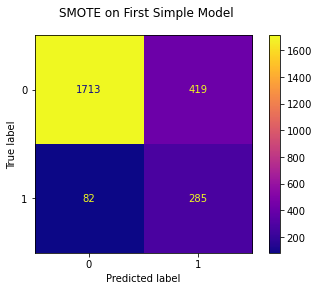

In [ ]:
# Training Data Confusion Matrix:

fig, ax = plt.subplots()

fig.suptitle("SMOTE on First Simple Model")

plot_confusion_matrix(smotepipe, X_train, y_train, ax=ax, cmap="plasma");

print(f'SMOTE model TRAIN Mean Accuracy score: {smotepipe.score(X_train, y_train):.5f}')
print()
print('Target value counts')
print(y_train.value_counts())

In [ ]:
# Fit SMOTE/FSM to training data using cross-validation on training data:
smote_pipe_cv = ModelWithCV(
    smotepipe,
    model_name='smote',
    X=X_train,
    y=y_train
)


CV Results for `smote` model:
            Accuracy: 0.77591 ± 0.03372
            Log Loss: 0.50995
            10-fold Cross Validation Scores: [0.808      0.752      0.812      0.8        0.788      0.744
 0.808      0.704      0.756      0.78714859]
        


/Users/claire/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'CV Results for `smote` Model'}>

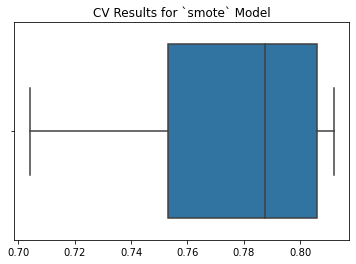

In [ ]:
fig, ax =plt.subplots()

smote_pipe_cv.print_cv_summary()

smote_pipe_cv.plot_cv(ax=ax)

## Interpretation:
- Because our mean accuracy decreased between training and validation, we may be able to conclude that our model is overfit.
- However, even though we applied SMOTE to adjust for imbalance, there is still a concern that accuracy is not a great indicator or model performance.
- For our next model, we'll concentrate on lowering log loss.
- We will use GridSearch as a way to try and tune hyperparameters.

# GridSearch - Hyperparameter Optimization
- Choosing how to set a hyperparameter is somewhat of a "black box" problem - it's difficult to determine or guess how to tune them.
- Thus, we want a way to conduct hyperparameter tuning, and we can accomplish via GridSearch.

## Define Search Space
- The search space is the "Volume to be searched where each dimension represents a hyperparameter and each point represents one model configuration." - Machine Learning Mastery: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

In [ ]:
smotepipe = ImPipeline(steps=[
    ('ct', ColTrans),
    ('sm', SMOTE(random_state=42)),
    ('lr', LogisticRegression(solver='saga'))
])

In [ ]:
smotepipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                 

In [ ]:
param_grid_lr=[{'lr__solver':['saga'],'lr__C':[0.1,1,10],'lr__penalty':['elasticnet','l1','l2']},
               {'lr__max_iter':[1000,2000,3000,4000]},
               {'lr__solver':['lbfgs'],'lr__C':[0.1,1,10], 'lr__l1_ratio':[.5]}
               
               ]

gspipe=GridSearchCV(smotepipe,param_grid_lr)
gs = gspipe.fit(X_train,y_train)
Suppress Warning filter warnings

/Users/claire/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/claire/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/claire/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/claire/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1312, in fit
    raise ValueError("l1_ratio must be between 0 and 1;"
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/claire/anaconda3/envs/learn-env/li

In [ ]:
print('Best Hyperparameters: %s' % gs.best_params_)

Best Hyperparameters: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'saga'}


In [ ]:
gs_best = gs.best_estimator_

GridSearch model TRAIN Mean Accuracy score: 0.79432

Target value counts
0    2132
1     367
Name: churn, dtype: int64


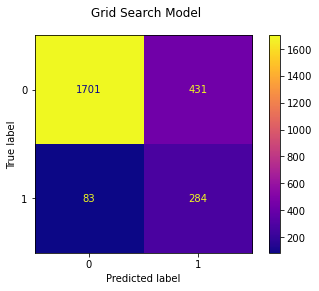

In [ ]:
# Training Data Confusion Matrix:

fig, ax = plt.subplots()

fig.suptitle("Grid Search Model")

plot_confusion_matrix(gs_best, X_train, y_train, ax=ax, cmap="plasma");

print(f'GridSearch model TRAIN Mean Accuracy score: {gs_best.score(X_train, y_train):.5f}')
print()
print('Target value counts')
print(y_train.value_counts())

In [ ]:
# Fit SMOTE/FSM to training data using cross-validation on training data:
gs_pipe_cv = ModelWithCV(
    gs_best,
    model_name='gs',
    X=X_train,
    y=y_train
)

CV Results for `gs` model:
            Accuracy: 0.78512 ± 0.03111
            Log Loss: 0.49866
            10-fold Cross Validation Scores: [0.812      0.776      0.82       0.808      0.788      0.764
 0.816      0.716      0.756      0.79518072]
        


/Users/claire/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'CV Results for `gs` Model'}>

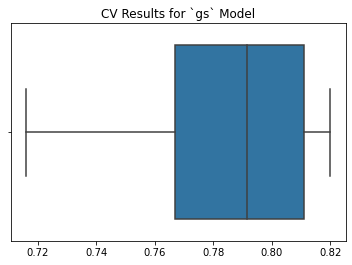

In [ ]:
fig, ax =plt.subplots()

gs_pipe_cv.print_cv_summary()

gs_pipe_cv.plot_cv(ax=ax)